In [2]:
import pyodbc
import pandas as pd
import numpy as np
import os
import logging

In [42]:
import pandas as pd
import pyodbc
import logging
import os
from functools import reduce

# Configura logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Configuración de conexión
AZURE_SERVER = 'uaxmathfis.database.windows.net'
AZURE_DATABASE = 'usecases'
AZURE_DRIVER = '{ODBC Driver 17 for SQL Server}'
CSV_PATH = 'datos_combinados.csv'

def get_azure_connection():
    """Establece conexión con Azure SQL usando autenticación interactiva"""
    conn_str = f"DRIVER={AZURE_DRIVER};SERVER={AZURE_SERVER};DATABASE={AZURE_DATABASE};Authentication=ActiveDirectoryInteractive"
    try:
        conn = pyodbc.connect(conn_str)
        logging.info("Conexión exitosa a Azure SQL")
        return conn
    except Exception as e:
        logging.error(f"Error de conexión: {e}")
        return None

def download_and_combine_tables():
    """Descarga todas las tablas y las combina correctamente por fecha"""
    # Eliminar el archivo CSV si existe
    if os.path.exists(CSV_PATH):
        try:
            os.remove(CSV_PATH)
            logging.info(f"Archivo existente {CSV_PATH} eliminado")
        except Exception as e:
            logging.error(f"No se pudo eliminar {CSV_PATH}: {e}")

    queries = {
        'MMM01_WEB': "SELECT * FROM DATAEX.MMM01_WEB",
        'MMM02_VISIT': "SELECT * FROM DATAEX.MMM02_VISIT",
        'MMM03_OFFLINE': "SELECT * FROM DATAEX.MMM03_OFFLINE",
        'MMM04_TIME': "SELECT * FROM DATAEX.MMM04_TIME",
        'MMM05_INV': "SELECT * FROM DATAEX.MMM05_INV"
    }

    conn = get_azure_connection()
    if not conn:
        return pd.DataFrame()

    try:
        # Descargar todas las tablas
        dfs = {}
        for name, query in queries.items():
            try:
                df = pd.read_sql(query, conn)
                if 'ID_Date' in df.columns:
                    df['ID_Date'] = pd.to_datetime(df['ID_Date'].astype(str), format=('%Y%m'))
                    df = df.drop_duplicates(subset=['ID_Date'])
                    # Agregamos el nombre de la tabla como prefijo a las columnas
                    df.columns = [f'{name}_{col}' if col != 'ID_Date' else col for col in df.columns]
                    dfs[name] = df.set_index('ID_Date')
                    logging.info(f"Tabla {name} descargada ({len(df)} registros)")
                else:
                    logging.warning(f"Tabla {name} no tiene columna ID_Date")
            except Exception as e:
                logging.error(f"Error procesando {name}: {e}")

        # Combinar horizontalmente por fecha
        if dfs:
            # Fusionar todas las tablas usando merge secuencial
            combined = reduce(lambda left, right: pd.merge(
                left, right, 
                left_index=True, right_index=True, 
                how='outer'
            ), dfs.values())
            
            # Guardar a CSV (se creará nuevo archivo)
            combined.to_csv(CSV_PATH)
            logging.info(f"Nuevo archivo {CSV_PATH} creado ({len(combined)} registros combinados)")
            return combined
        else:
            logging.warning("No se descargaron datos válidos")
            return pd.DataFrame()

    finally:
        conn.close()

def load_from_csv():
    """Carga los datos previamente guardados desde el CSV"""
    try:
        if os.path.exists(CSV_PATH):
            return pd.read_csv(CSV_PATH, parse_dates=['ID_Date'], index_col='ID_Date')
        else:
            logging.warning(f"Archivo {CSV_PATH} no encontrado")
            return pd.DataFrame()
    except Exception as e:
        logging.error(f"Error cargando CSV: {e}")
        return pd.DataFrame()

# Ejecutar la descarga (siempre creará nuevo archivo)
df = download_and_combine_tables()

# Para cargar los datos posteriormente (si el archivo existe)
# df = load_from_csv()

if not df.empty:
    print("\nDatos combinados correctamente:")
    print(f"Total de registros: {len(df)}")
    print(f"Columnas: {len(df.columns)}")
    print("\nPrimeras filas:")
    df.head()
else:
    print("No hay datos disponibles")

2025-03-28 17:19:12,532 - INFO - Archivo existente datos_combinados.csv eliminado
2025-03-28 17:19:13,475 - INFO - Conexión exitosa a Azure SQL
2025-03-28 17:19:13,575 - INFO - Tabla MMM01_WEB descargada (36 registros)
2025-03-28 17:19:13,664 - INFO - Tabla MMM02_VISIT descargada (36 registros)
2025-03-28 17:19:13,757 - INFO - Tabla MMM03_OFFLINE descargada (36 registros)
2025-03-28 17:19:13,844 - INFO - Tabla MMM04_TIME descargada (36 registros)
2025-03-28 17:19:13,928 - INFO - Tabla MMM05_INV descargada (36 registros)
2025-03-28 17:19:13,934 - INFO - Nuevo archivo datos_combinados.csv creado (36 registros combinados)



Datos combinados correctamente:
Total de registros: 36
Columnas: 46

Primeras filas:


In [43]:
df = load_from_csv()
df = df.reset_index()

df

,ID_Date,MMM01_WEB_Unique_visitors,MMM01_WEB_PDFBrochuresDownloaded,MMM01_WEB_ProductConfigurator,MMM01_WEB_Product_configurator_Visists,MMM01_WEB_SocialNetworks,MMM01_WEB_DirectTraffic,MMM01_WEB_EMail,MMM01_WEB_NaturalSearch,MMM01_WEB_OnlineMedia,...,MMM05_INV_CINE,MMM05_INV_EXTERIOR,MMM05_INV_INTERNET,MMM05_INV_PRENSA,MMM05_INV_PRODUCCION,MMM05_INV_RADIO,MMM05_INV_REVISTAS,MMM05_INV_PlataformasVideo,MMM05_INV_VARIOS,MMM05_INV_INV_Total
0,2022-01-01,272382,4838,33222,94248,1415,65373,25,167199,63649,...,59887.840,8200.00,133666.43000,0.00000,6050.00,2426.40,18013.5000,338824.940,7531.0300,5.746001e+05
1,2022-02-01,352581,5823,38570,109531,546,77209,26,176733,124861,...,72291.560,94627.51,189275.94000,10000.00000,6700.00,0.00,49110.9100,487537.140,6972.0200,9.165151e+05
2,2022-03-01,332955,4845,33956,97805,5444,83178,341,173514,104132,...,55000.000,0.00,214037.62000,4500.00000,3700.00,0.00,0.0000,75000.000,15284.8500,3.675225e+05
3,2022-04-01,282169,3711,45949,90689,1184,69335,162,162805,74044,...,10883.300,0.00,194816.97000,48800.00000,21550.00,1140.00,40876.0000,610865.890,12255.7500,9.411879e+05
4,2022-05-01,261829,9037,48685,92069,8648,70972,210,156011,44196,...,74333.200,0.00,130795.16000,11000.00000,4900.00,102851.86,20775.7500,393807.740,7926.4600,7.463902e+05
5,2022-06-01,201141,10727,38608,73421,1082,61455,2374,134355,15600,...,37400.000,0.00,67827.66000,0.00000,12250.00,5526.49,75573.1300,0.000,5405.7200,2.039830e+05
6,2022-07-01,206538,11023,38912,74564,909,66835,204,144300,11000,...,58816.500,0.00,61897.17000,0.00000,650.00,158.40,2600.0000,1500.000,4574.5000,1.301966e+05
7,2022-08-01,259903,15743,47613,88335,7511,78704,14,172986,15205,...,0.000,0.00,46362.01000,13000.00000,9750.00,345.60,33860.0000,391987.870,28716.2600,5.240217e+05
8,2022-09-01,261618,14130,44164,83840,1773,58630,199,174125,41832,...,39483.300,0.00,77470.41000,9507.80000,7850.00,2686.80,14580.0000,0.000,6645.2700,1.582236e+05
9,2022-10-01,396642,16321,53200,100262,2117,74040,874,203699,162588,...,45733.200,0.00,271750.66000,0.00000,20300.00,3162.00,117786.9700,804181.400,14421.1300,1.277335e+06


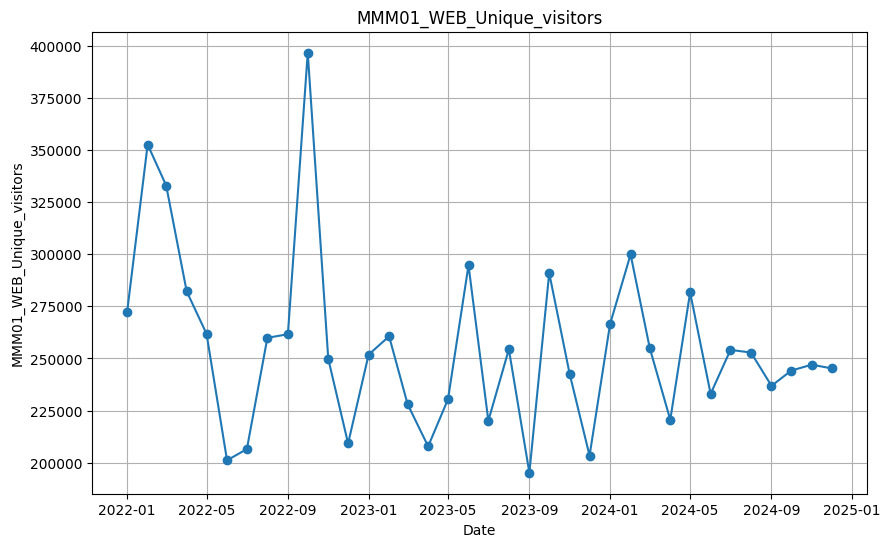

In [44]:
import matplotlib.pyplot as plt

# Convertir la columna 'Date' a tipo datetime y establecerla como índice
df['ID_Date'] = pd.to_datetime(df['ID_Date'], format='%d.%m.%Y')
df.set_index('ID_Date', inplace=True)

# Convertir los datos diarios a datos mensuales tomando el primer día de cada mes
df_monthly = df.resample('MS').mean().asfreq('MS')

# Filtrar todas las filas donde 'Revenue' no sea nulo o NaN
df_monthly_filtered = df_monthly.dropna(subset=['MMM01_WEB_Unique_visitors'])

# Graficar la columna 'Revenue'
plt.figure(figsize=(10, 6))
plt.plot(df_monthly_filtered.index, df_monthly_filtered['MMM01_WEB_Unique_visitors'], marker='o', linestyle='-')
plt.title('MMM01_WEB_Unique_visitors')
plt.xlabel('Date')
plt.ylabel('MMM01_WEB_Unique_visitors')
plt.grid(True)
plt.show()

In [45]:
# Dividir los datos en conjunto de entrenamiento y conjunto de prueba (80% entrenamiento, 20% prueba)
train_size = int(len(df_monthly_filtered) * 0.8)
train, test = df_monthly_filtered.iloc[:train_size], df_monthly_filtered.iloc[train_size:]

In [ ]:
import itertools
import warnings
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')

def find_best_sarima(train, seasonal_period=12, max_pdq=3, max_PDQ=1):
    """
    Encuentra los mejores parámetros SARIMA mediante búsqueda en grilla
    
    Args:
        train: Serie temporal de entrenamiento
        seasonal_period: Periodicidad estacional (12 para mensual)
        max_pdq: Máximo valor para p, d, q
        max_PDQ: Máximo valor para P, D, Q
        
    Returns:
        Mejores parámetros encontrados y métricas de evaluación
    """
    # 1. Definir rangos de parámetros
    p = d = q = range(0, max_pdq+1)
    P = D = Q = range(0, max_PDQ+1)
    
    # 2. Generar todas las combinaciones posibles
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], seasonal_period) for x in list(itertools.product(P, D, Q))]
    
    # 3. Variables para almacenar resultados
    best_aic = np.inf
    best_bic = np.inf
    best_order = None
    best_seasonal_order = None
    results = []
    
    # 4. Búsqueda exhaustiva
    for order in pdq:
        for seasonal_order in seasonal_pdq:
            try:
                model = SARIMAX(train,
                              order=order,
                              seasonal_order=seasonal_order,
                              enforce_stationarity=False,
                              enforce_invertibility=False)
                fit = model.fit(disp=False)
                
                # Registrar resultados
                results.append({
                    'order': order,
                    'seasonal_order': seasonal_order,
                    'aic': fit.aic,
                    'bic': fit.bic
                })
                
                # Actualizar mejor modelo
                if fit.aic < best_aic:
                    best_aic = fit.aic
                    best_order = order
                    best_seasonal_order = seasonal_order
                    best_model = fit
                    
                print(f"SARIMA{order}x{seasonal_order} - AIC:{fit.aic:.1f}, BIC:{fit.bic:.1f}")
            except:
                continue
    
    # 5. Resultados ordenados por AIC
    results_df = pd.DataFrame(results).sort_values('aic')
    
    return {
        'best_model': best_model,
        'best_order': best_order,
        'best_seasonal_order': best_seasonal_order,
        'best_aic': best_aic,
        'results': results_df
    }

# Uso del código con tus datos
best_sarima = find_best_sarima(train, seasonal_period=12)

# Mostrar mejores parámetros
print(f"\nMEJOR MODELO ENCONTRADO:")
print(f"SARIMA{best_sarima['best_order']}x{best_sarima['best_seasonal_order']}")
print(f"AIC: {best_sarima['best_aic']:.2f}")

# Ver top 5 modelos
print("\nTOP 5 MODELOS:")
print(best_sarima['results'].head(5))

Error con SARIMA(0, 0, 0)x(0, 0, 0, 12): SARIMAX models require univariate `endog`. Got shape (28, 46).
Error con SARIMA(0, 0, 0)x(0, 0, 1, 12): SARIMAX models require univariate `endog`. Got shape (28, 46).
Error con SARIMA(0, 0, 0)x(0, 1, 0, 12): SARIMAX models require univariate `endog`. Got shape (28, 46).
Error con SARIMA(0, 0, 0)x(0, 1, 1, 12): SARIMAX models require univariate `endog`. Got shape (28, 46).
Error con SARIMA(0, 0, 0)x(1, 0, 0, 12): SARIMAX models require univariate `endog`. Got shape (28, 46).
Error con SARIMA(0, 0, 0)x(1, 0, 1, 12): SARIMAX models require univariate `endog`. Got shape (28, 46).
Error con SARIMA(0, 0, 0)x(1, 1, 0, 12): SARIMAX models require univariate `endog`. Got shape (28, 46).
Error con SARIMA(0, 0, 0)x(1, 1, 1, 12): SARIMAX models require univariate `endog`. Got shape (28, 46).
Error con SARIMA(0, 0, 1)x(0, 0, 0, 12): SARIMAX models require univariate `endog`. Got shape (28, 46).
Error con SARIMA(0, 0, 1)x(0, 0, 1, 12): SARIMAX models require 

In [50]:
# Buscar los mejores parámetros con AutoARIMA
stepwise_model = auto_arima(train, 
                            start_p=1, start_q=1,
                            max_p=3, max_q=3,
                            d=None,  # Dejar que autoARIMA determine el mejor 'd'
                            start_P=1, start_Q=1,
                            max_P=2, max_Q=2,
                            m=12,    # Estacionalidad anual para datos mensuales
                            D=None,  # Dejar que autoARIMA determine el mejor 'D'
                            seasonal=True,
                            trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

# Mostrar los parámetros encontrados
print(stepwise_model.summary())


ValueError: y should be a 1d array, got an array of shape (28, 46) instead.

Métricas del Modelo SARIMA (0, 3, 0)(0, 1, 1, 12): (1521473392.3208323, 33927.13354477108, 39006.06866015636, -6.854460417773412)


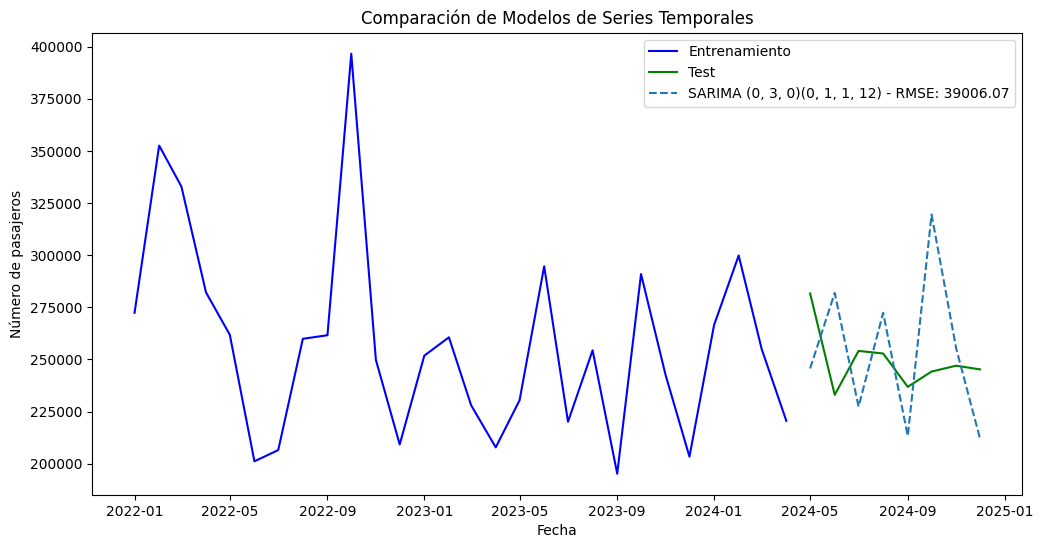

ARIMA - AIC: 399.56362117123285 BIC: 405.7443309491511
SARIMA - AIC: 399.56362117123285 BIC: 405.7443309491511

Coeficientes SARIMA (0, 3, 0)(0, 1, 1, 12):
                                      SARIMAX Results                                       
Dep. Variable:            MMM01_WEB_Unique_visitors   No. Observations:                   28
Model:             SARIMAX(1, 0, 4)x(1, 1, [1], 12)   Log Likelihood                -191.782
Date:                             vi., 28 mar. 2025   AIC                            399.564
Time:                                      17:23:18   BIC                            405.744
Sample:                                  01-01-2022   HQIC                           399.880
                                       - 04-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------

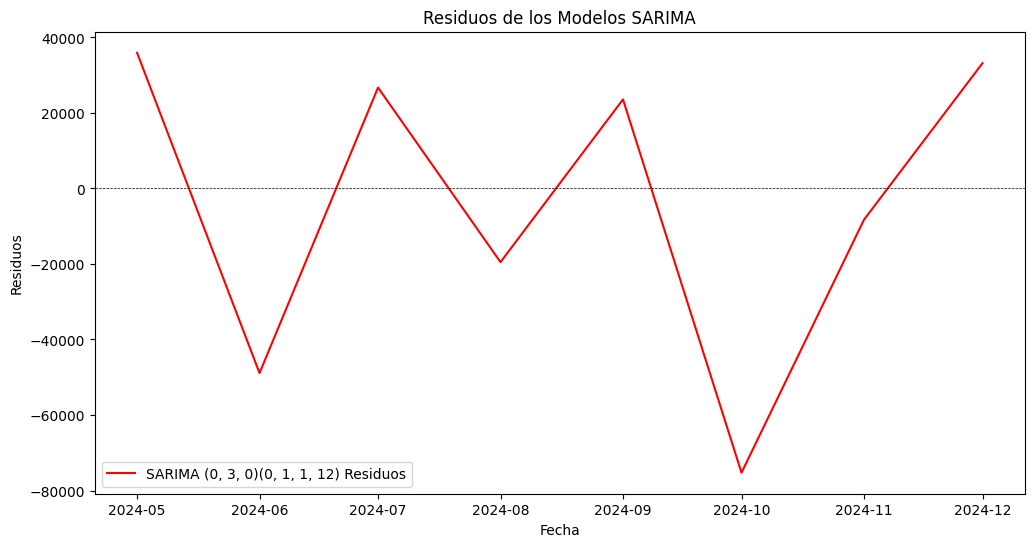

                Fecha  SARIMA (0, 3, 0)(0, 1, 1, 12) Residuos
ID_Date                                                      
2024-05-01 2024-05-01                            35947.043272
2024-06-01 2024-06-01                           -48893.648860
2024-07-01 2024-07-01                            26717.714492
2024-08-01 2024-08-01                           -19521.726101
2024-09-01 2024-09-01                            23583.734865
2024-10-01 2024-10-01                           -75291.301965
2024-11-01 2024-11-01                            -8289.947953
2024-12-01 2024-12-01                            33171.950851


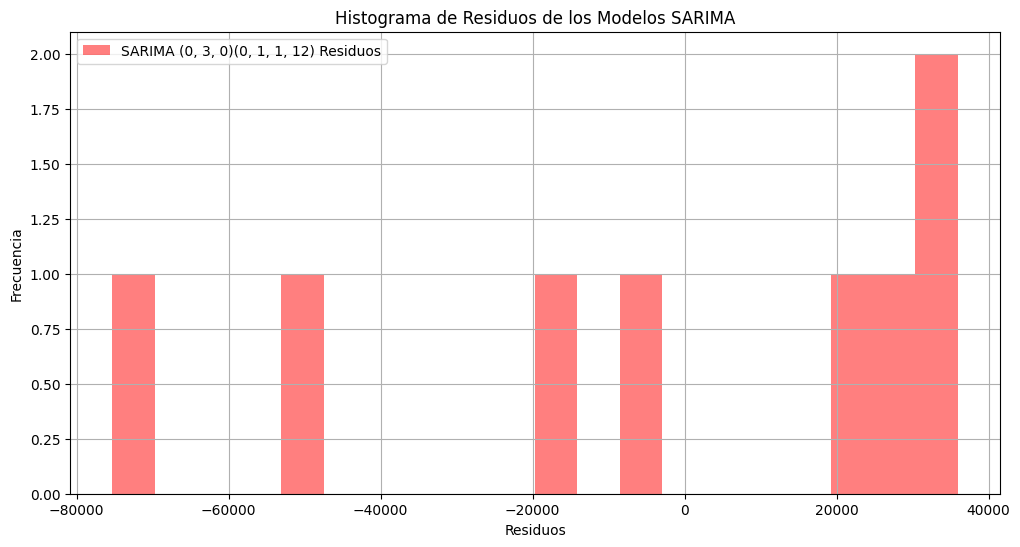

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ARIMA, SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Ajustar y predecir el modelo SARIMA
sarima_model2 = SARIMAX(train['MMM01_WEB_Unique_visitors'], order=(1, 0, 4), seasonal_order=(1, 1, 1, 12))
sarima_fit2 = sarima_model2.fit()
sarima_predictions2 = sarima_fit2.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')

# Calcular métricas de validación para cada modelo
def calcular_metricas(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, rmse, r2

# Calculamos las métricas para cada modelo

sarima_metrics2 = calcular_metricas(test['MMM01_WEB_Unique_visitors'], sarima_predictions2)

# Imprimir las métricas

print("Métricas del Modelo SARIMA (0, 3, 0)(0, 1, 1, 12):", sarima_metrics2)

# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['MMM01_WEB_Unique_visitors'], label='Entrenamiento', color='blue')
plt.plot(test.index, test['MMM01_WEB_Unique_visitors'], label='Test', color='green')

plt.plot(test.index, sarima_predictions2, label=f'SARIMA (0, 3, 0)(0, 1, 1, 12) - RMSE: {sarima_metrics2[2]:.2f}', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Número de pasajeros')
plt.title('Comparación de Modelos de Series Temporales')
plt.legend()
plt.show()

# Imprimir AIC y BIC
print("ARIMA - AIC:", sarima_fit2.aic, "BIC:", sarima_fit2.bic)
print("SARIMA - AIC:", sarima_fit2.aic, "BIC:", sarima_fit2.bic)

# Imprimir coeficientes

print("\nCoeficientes SARIMA (0, 3, 0)(0, 1, 1, 12):")
print(sarima_fit2.summary())

# Obtener los residuos de cada modelo

sarima_residuals2 = test['MMM01_WEB_Unique_visitors'] - sarima_predictions2

# Graficar los residuos
plt.figure(figsize=(12, 6))

plt.plot(test.index, sarima_residuals2, label='SARIMA (0, 3, 0)(0, 1, 1, 12) Residuos', color='red')
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.xlabel('Fecha')
plt.ylabel('Residuos')
plt.title('Residuos de los Modelos SARIMA')
plt.legend()
plt.show()

# Crear un DataFrame para los residuos
residuals_df = pd.DataFrame({
    'Fecha': test.index,
   
    'SARIMA (0, 3, 0)(0, 1, 1, 12) Residuos': sarima_residuals2
})

# Mostrar la tabla de resultados
print(residuals_df)

# Obtener los residuos de cada modelo

sarima_residuals2 = test['MMM01_WEB_Unique_visitors'] - sarima_predictions2

# Graficar un histograma de los residuos
plt.figure(figsize=(12, 6))

plt.hist(sarima_residuals2, bins=20, color='red', alpha=0.5, label='SARIMA (0, 3, 0)(0, 1, 1, 12) Residuos')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Histograma de Residuos de los Modelos SARIMA')
plt.legend()
plt.grid(True)
plt.show()

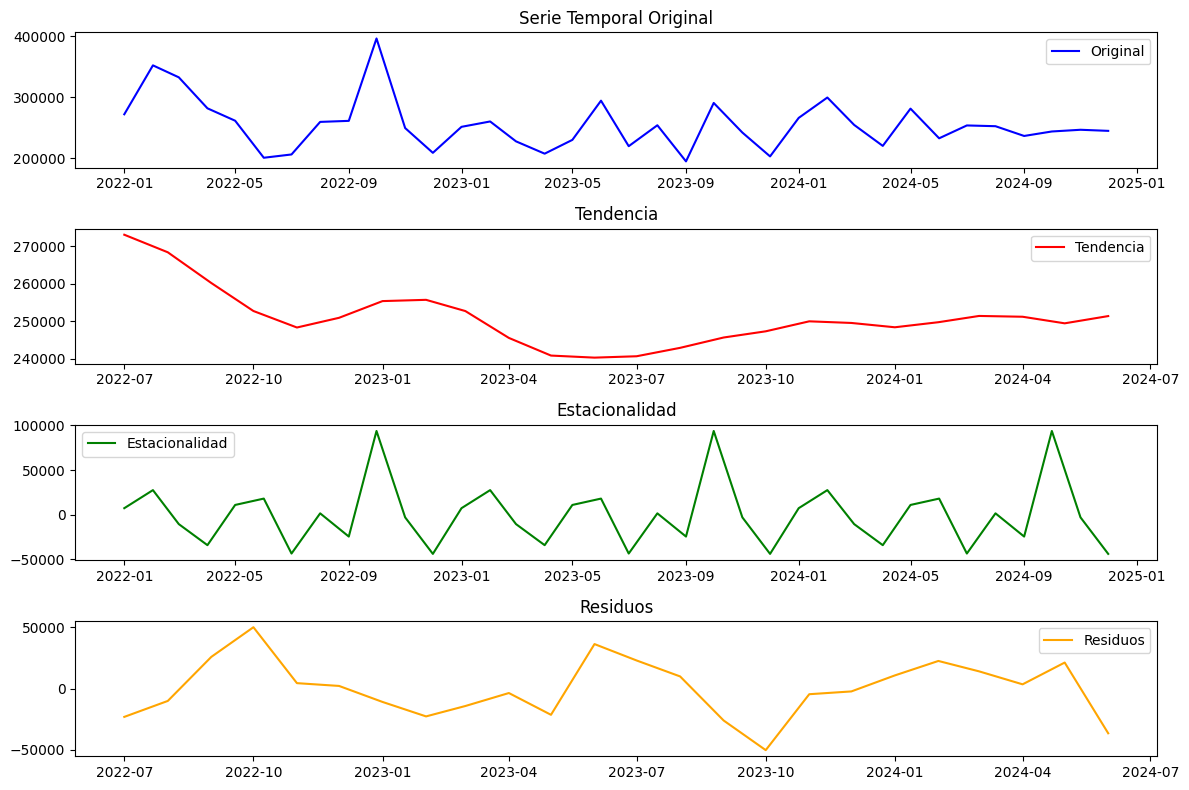

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


# Descomposición de la serie temporal
decomposition = seasonal_decompose(df['MMM01_WEB_Unique_visitors'], model='additive')

# Obtención de las componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residuals = decomposition.resid

# Graficar las componentes
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(df['MMM01_WEB_Unique_visitors'], label='Original', color='blue')
plt.legend()
plt.title('Serie Temporal Original')

plt.subplot(412)
plt.plot(trend, label='Tendencia', color='red')
plt.legend()
plt.title('Tendencia')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad', color='green')
plt.legend()
plt.title('Estacionalidad')

plt.subplot(414)
plt.plot(residuals, label='Residuos', color='orange')
plt.legend()
plt.title('Residuos')

plt.tight_layout()
plt.show()

c:\Users\aleja\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\aleja\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\aleja\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\aleja\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyw

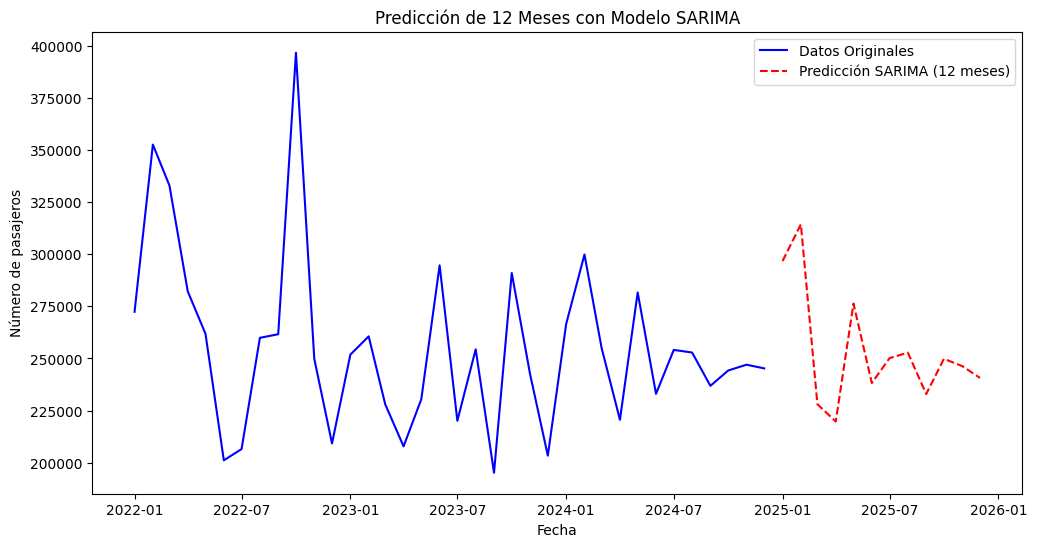

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SARIMAX
import numpy as np

# Ajustar el modelo SARIMA a todos los datos
sarima_model = SARIMAX(df['MMM01_WEB_Unique_visitors'], order=(0, 0, 3), seasonal_order=(0, 1, 1, 12))
sarima_fit = sarima_model.fit()

# Realizar la predicción de los próximos 6 meses
start_date = df.index[-1] + pd.DateOffset(months=1)
end_date = start_date + pd.DateOffset(months=11)
sarima_predictions_12months = sarima_fit.predict(start=start_date, end=end_date, typ='levels')

# Graficar las predicciones de los próximos 6 meses
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['MMM01_WEB_Unique_visitors'], label='Datos Originales', color='blue')
plt.plot(sarima_predictions_12months.index, sarima_predictions_12months, label='Predicción SARIMA (12 meses)', color='red', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Número de pasajeros')
plt.title('Predicción de 12 Meses con Modelo SARIMA')
plt.legend()
plt.show()


c:\Users\aleja\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\aleja\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\aleja\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


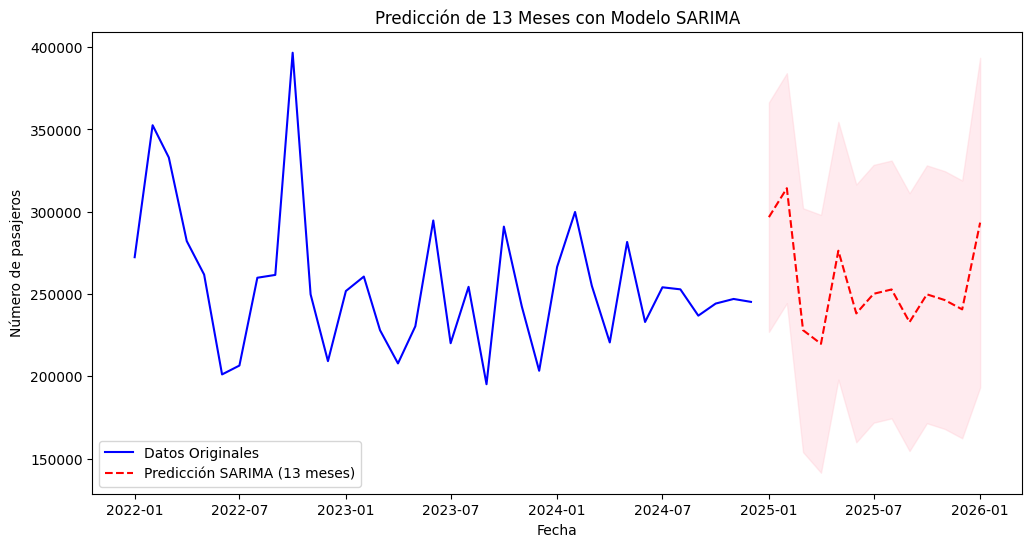

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SARIMAX

# Ajustar el modelo SARIMA a todos los datos
sarima_model = SARIMAX(df['MMM01_WEB_Unique_visitors'], order=(0, 0, 3), seasonal_order=(0, 1, 1, 12))
sarima_fit = sarima_model.fit()

# Obtener predicciones y sus intervalos de confianza para los próximos 12 meses
forecast = sarima_fit.get_forecast(steps=13)  # Predicción de 12 meses + 1 (13 meses en total)
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Graficar las predicciones de los próximos 12 meses con intervalo de confianza
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['MMM01_WEB_Unique_visitors'], label='Datos Originales', color='blue')
plt.plot(forecast_values.index, forecast_values, label='Predicción SARIMA (13 meses)', color='red', linestyle='--')
plt.fill_between(forecast_values.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Fecha')
plt.ylabel('Número de pasajeros')
plt.title('Predicción de 13 Meses con Modelo SARIMA')
plt.legend()
plt.show()


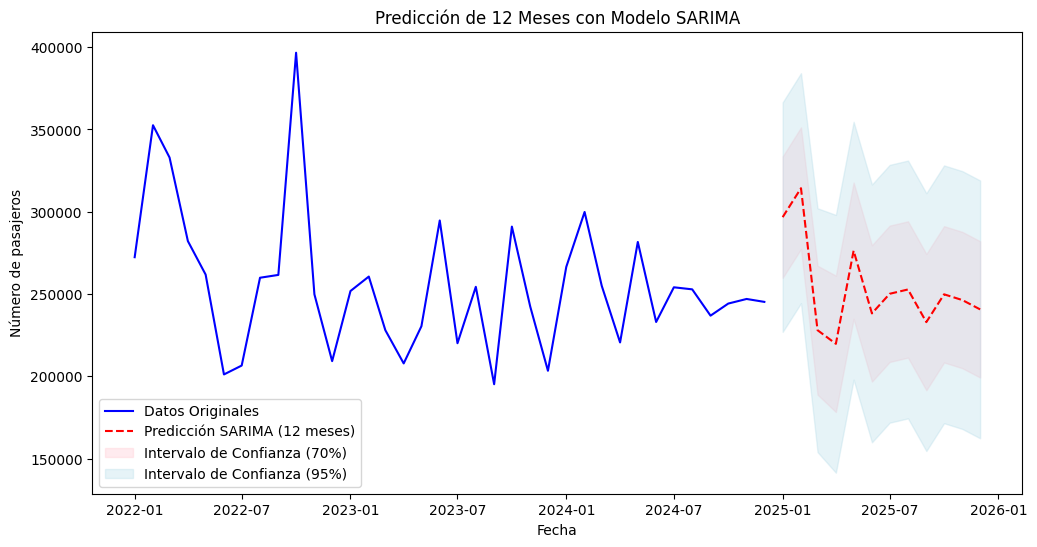

In [32]:
# Obtener los intervalos de confianza del 70% y 95%
confidence_intervals_70 = sarima_fit.get_forecast(steps=12).conf_int(alpha=0.3)
confidence_intervals_95 = sarima_fit.get_forecast(steps=12).conf_int(alpha=0.05)

# Graficar las predicciones de los próximos 12 meses con intervalo de confianza
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['MMM01_WEB_Unique_visitors'], label='Datos Originales', color='blue')
plt.plot(sarima_predictions_12months.index, sarima_predictions_12months, label='Predicción SARIMA (12 meses)', color='red', linestyle='--')
plt.fill_between(sarima_predictions_12months.index, confidence_intervals_70.iloc[:, 0], confidence_intervals_70.iloc[:, 1], color='pink', alpha=0.3, label='Intervalo de Confianza (70%)')
plt.fill_between(sarima_predictions_12months.index, confidence_intervals_95.iloc[:, 0], confidence_intervals_95.iloc[:, 1], color='lightblue', alpha=0.3, label='Intervalo de Confianza (95%)')
plt.xlabel('Fecha')
plt.ylabel('Número de pasajeros')
plt.title('Predicción de 12 Meses con Modelo SARIMA')
plt.legend()
plt.show()
